In [2]:
#import ALL THE THINGS
from IPython.core import display as ICD

import numpy as np
import numpy.lib.recfunctions as rf

import matplotlib.pyplot as plt
import mpld3

from ema_workbench import (load_results, ema_logging)
from ema_workbench.analysis import prim
from ema_workbench.analysis import cart

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Run PRIM Analysis

PRIM is a method of sensitivity discovery that focuses on what inputs have the largest effect on an output region of interest. It foucses on finding the minimum set of inputs that create a target output level. 

By running PRIM first on the open model, we can determine the relevant pressure points when developing policies change the outcomes of the model.  

This script accepts an already generated output set, which can be built in the RunExperiments notebook. For the purposes of running this script, all results files can be found in the `./data/` directory. 

### Targets
When running PRIM with the Disease model for EPA1361, we will foucs on inputs that cause the 'Deceased population' and 'Infectious population' to rise above specified levels. 

Traditionally, stakeholder analysis is useful in determining target values, but due to the nature of this project, these targets were developed through research into infectious disease tipping points, as well as the open exploration found in `01_OpenExploration.ipynb`: 
* Infectious population > 20% 
* Deceased population > 10%

### Parameters
The key parameters in PRIM analysis are the threshold of coverage and the peeling alpha: 

**Threshold**: The minimum threshold of coverage (how many of the relevant data sets are inside the box) that the algorithm should meet before stopping. In our case, the threshold we used is 0.8, or 80% coverage.

**Peeling Alpha**: The peeling alpha refers to how much data is "peeled off" over each iteration of the algorithm. We left the peeling trajectory at the default 0.05 for this run. 

In [3]:
infectious_max = 0.2
deceased_max = 0.1
population = 100000

In [ ]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./data/category_LHS_1200.tar.gz')

In [5]:
experiments, outcomes = results

### Cases of interest
Determine the percentage of total cases that fall below the threshold

In [6]:
deceased = outcomes['Deceased population']
infectious = np.max(outcomes['Infectious population'], axis=1)

#make an empty array of length equal to number of cases 
deceased_threshold = np.zeros(deceased.shape[0])
infectious_threshold = np.zeros(infectious.shape[0])
#if deceased population is higher then 10,000 people, classify as 1 
deceased_threshold[deceased[:, -1] > deceased_max*population] = 1
infectious_threshold[infectious > infectious_max*population] = 1

totalDeceased = np.sum(deceased_threshold)
totalInfectious = np.sum(infectious_threshold)

print('{}% of cases are above the deceased threshold.'.format(int(totalDeceased/len(deceased_threshold)*100)))
print('{}% of cases are above the infectious threshold.'.format(int(totalInfectious/len(infectious_threshold)*100)))

60% of cases are above the deceased threshold.
52% of cases are above the infectious threshold.


# Deceased Analysis

In [7]:
def classifyDeceased(data):
    ooi = 'Deceased population'
    result = data[ooi]
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result.shape[0])
    
    #if deceased population is higher then 10,000 people, classify as 1 
    classes[result[:, -1] > deceased_max*population] = 1
    
    return classes

deceased_prim = prim.setup_prim(results, classifyDeceased,  
                           threshold=0.8, threshold_type=1)
box1 = deceased_prim.find_box()

[MainProcess/INFO] 1200 points remaining, containing 727 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.485, coverage: 0.8005502063273727, density: 1.0 restricted_dimensions: 2.0


In [8]:
box1.show_tradeoff()
mpld3.display()

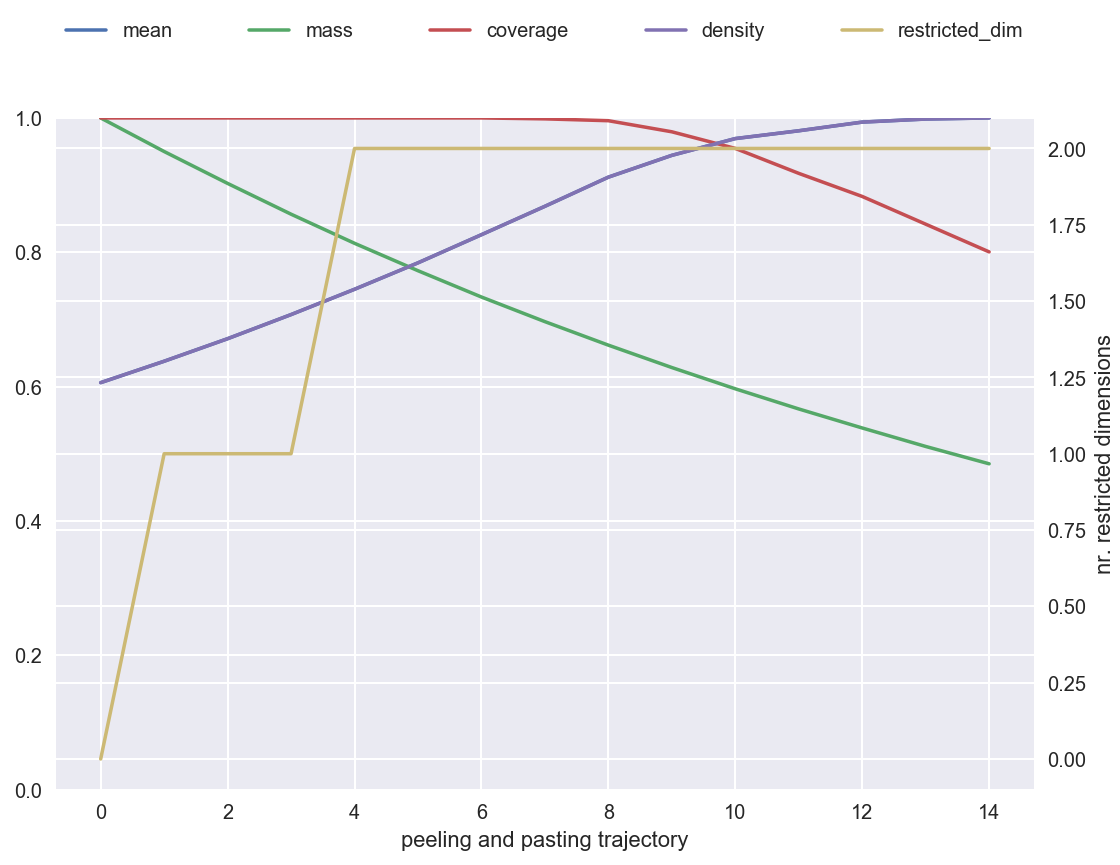

In [9]:
box1.show_ppt()
plt.show()

coverage    0.80055
density     1.00000
mass        0.48500
mean        1.00000
res dim     2.00000
Name: 14, dtype: float64

                             box 14                        
                                min       max     qp values
Basic reproduction number  2.221991  4.997808  5.426133e-70
Case fatality rate         0.123515  0.499818  3.816112e-51



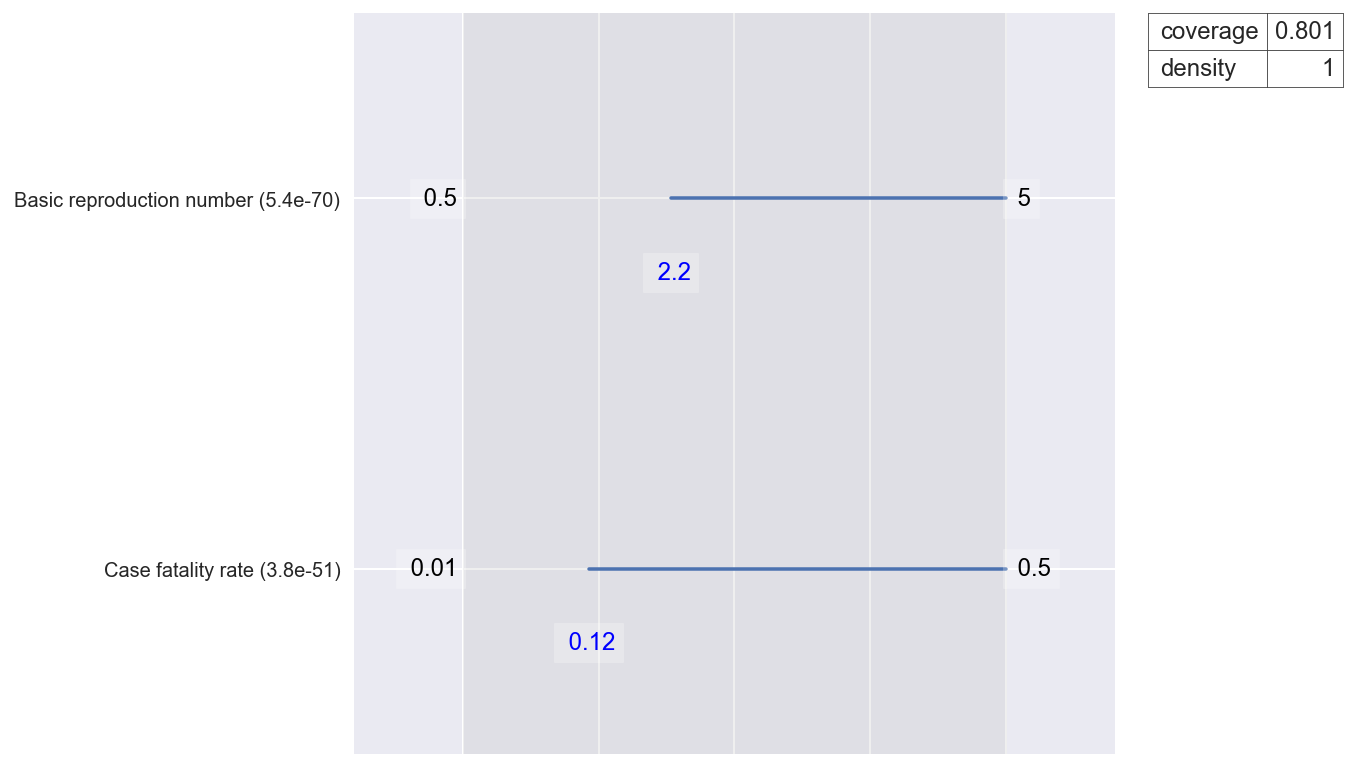

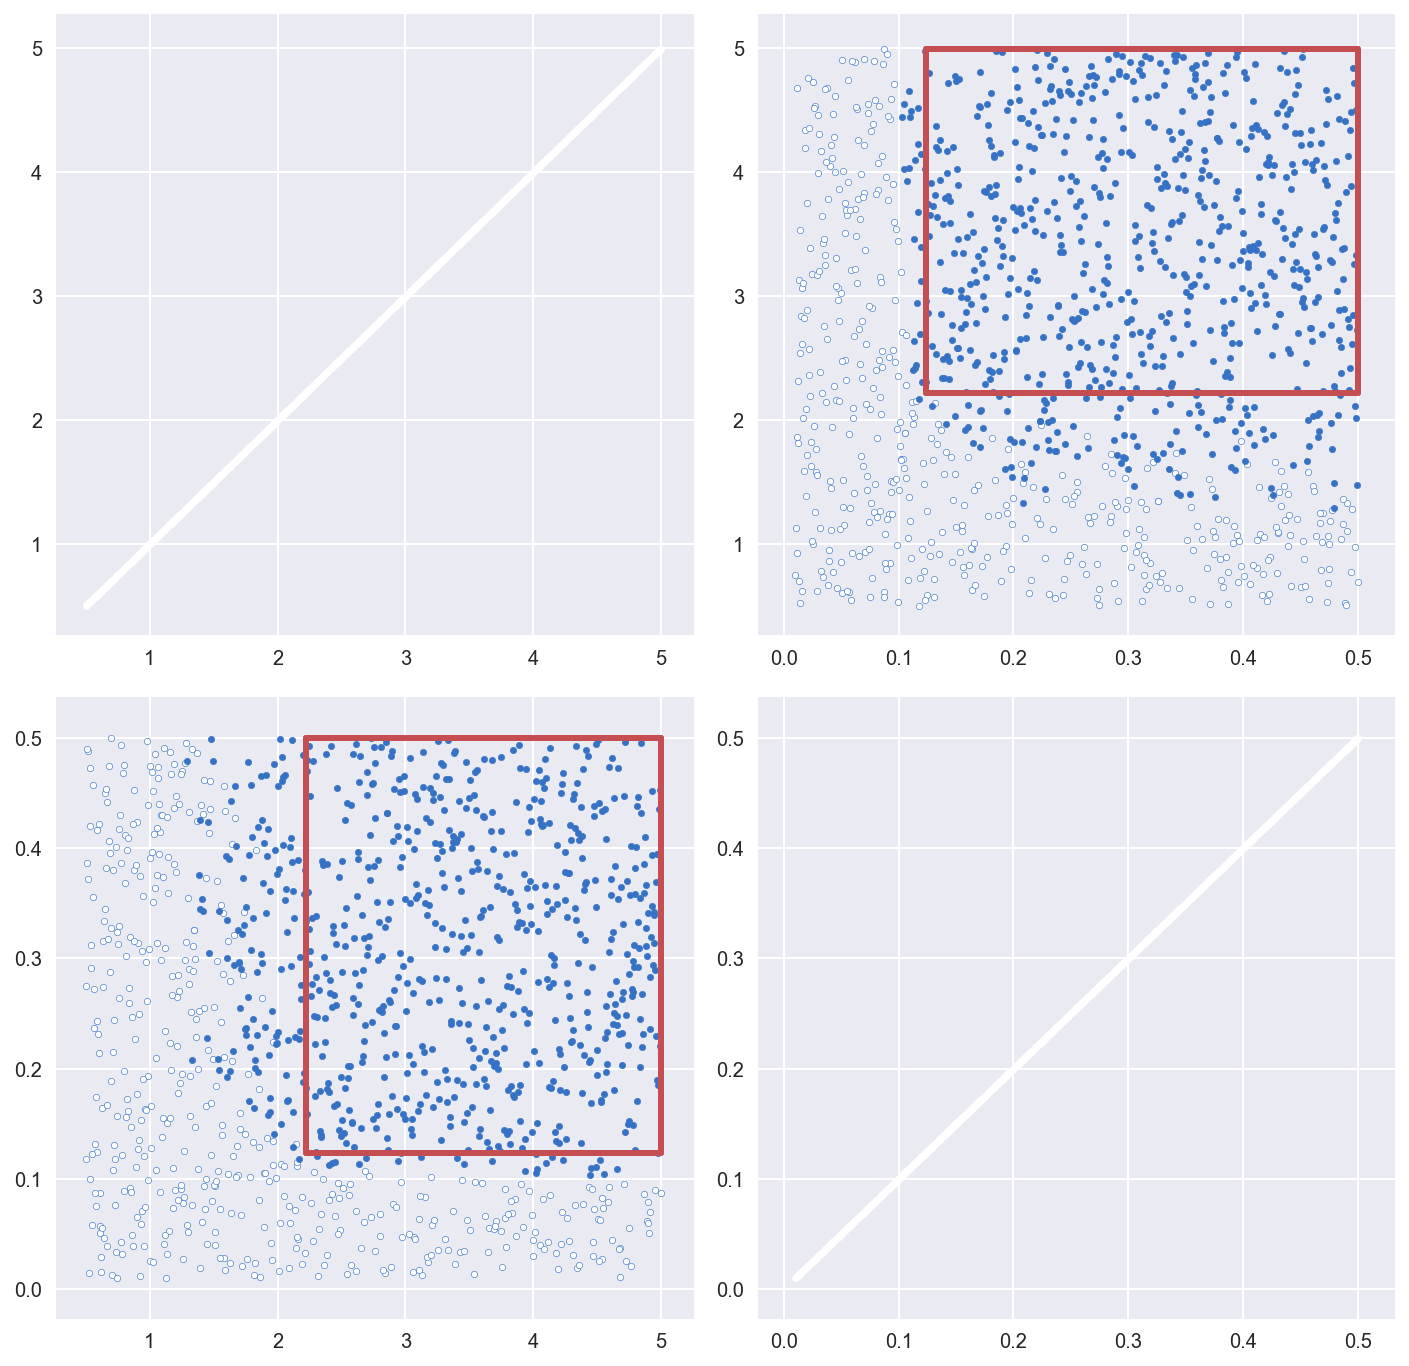

In [10]:
top_box = 14

box1.inspect(top_box)
box1.inspect(top_box, style='graph')

box1.select(top_box)
fig = box1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [11]:
box2 = deceased_prim.find_box()

[MainProcess/INFO] 618 points remaining, containing 145 cases of interest
[MainProcess/INFO] mean: 0.9090909090909091, mass: 0.10083333333333333, coverage: 0.15130674002751032, density: 0.9090909090909091 restricted_dimensions: 4.0


In [12]:
box3 = deceased_prim.find_box()

[MainProcess/INFO] 497 points remaining, containing 35 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.35714285714285715, returning dump box


In [13]:
ICD.display(deceased_prim.boxes_to_dataframe())
ICD.display(deceased_prim.stats_to_dataframe())

box 1               box 2                box 3  \
                                min       max       min       max        min   
Basic reproduction number   2.22199   4.99781   1.59973   4.99781   0.503083   
Case fatality rate         0.123515  0.499818  0.113498  0.499818  0.0101207   
Average infectious period   7.00656    20.998   7.00656   19.8183    7.00656   
Average incubation time    0.500041   13.9901  0.500041   11.7337   0.500041   

                                     
                                max  
Basic reproduction number   4.99781  
Case fatality rate         0.499818  
Average infectious period    20.998  
Average incubation time     13.9901

,coverage,density,mass,res_dim
box 1,0.800550,1.000000,0.485000,2.0
box 2,0.151307,0.909091,0.100833,4.0
box 3,0.048143,0.070423,0.414167,0.0


# Infectious Analysis

In [14]:
def classifyInfectious(data):
    ooi_i = 'Infectious population'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_i.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_i > infectious_max*population)] = 1
    
    return classes

infectious_prim = prim.setup_prim(results, classifyInfectious,  
                           threshold=0.8, threshold_type=1)
box1 = infectious_prim.find_box()

[MainProcess/INFO] 1200 points remaining, containing 631 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.30083333333333334, coverage: 0.572107765451664, density: 1.0 restricted_dimensions: 2.0


In [15]:
tradeoff = box1.show_tradeoff()
mpld3.display(tradeoff)

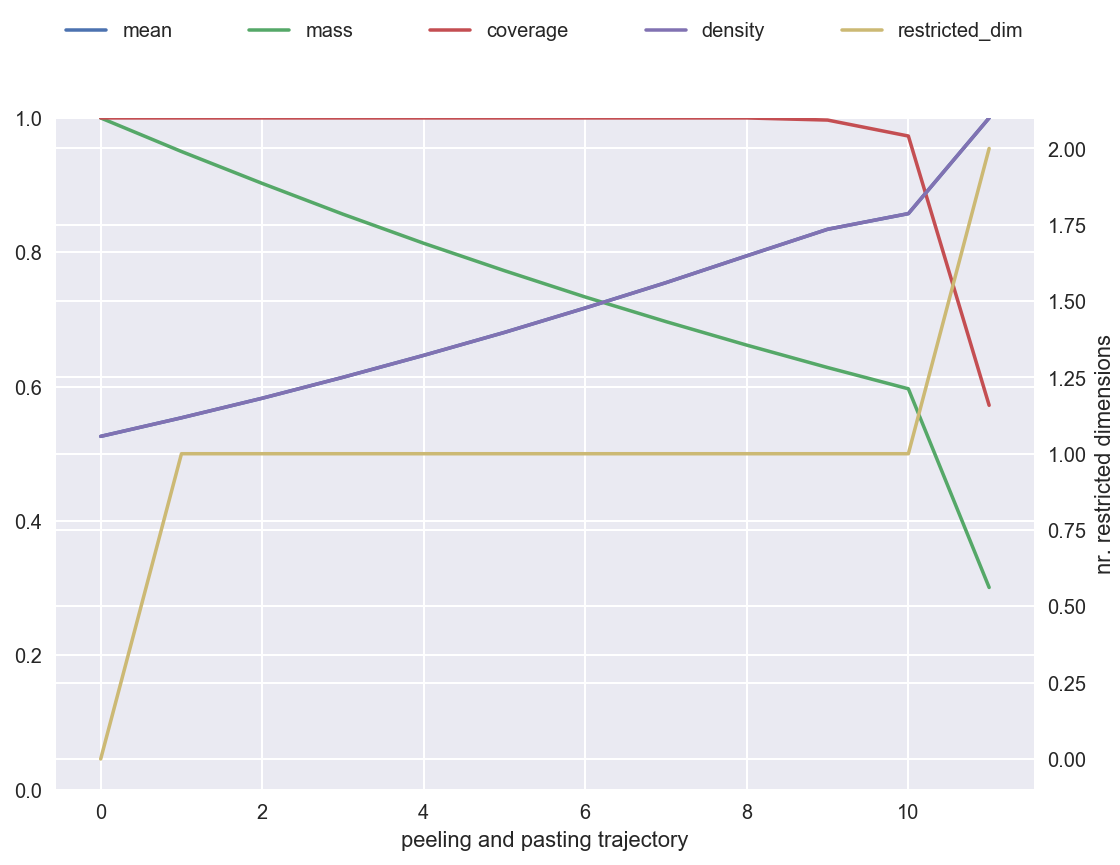

In [16]:
box1.show_ppt()
plt.show()

coverage    0.572108
density     1.000000
mass        0.300833
mean        1.000000
res dim     2.000000
Name: 11, dtype: float64

                            box 11                       
                               min      max     qp values
Basic reproduction number  2.31461  4.99781  3.006947e-71
Switch SEIR or SIR             {0}      {0}  4.901195e-23



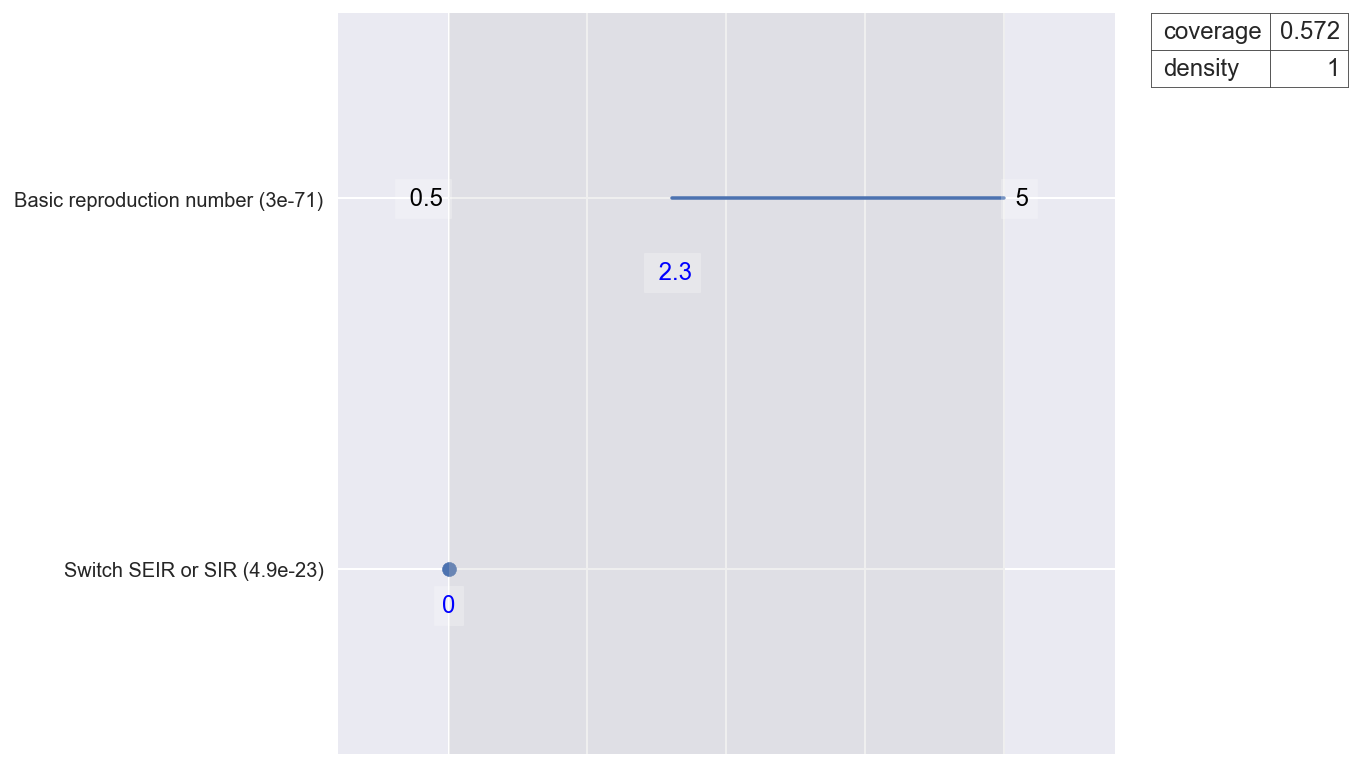

In [17]:
top_box = 11

box1.inspect(top_box)
box1.inspect(top_box, style='graph')

# there are problems with this when you run PRIM multiple 
# times in the same script 

# box1.select(top_box)
# fig = box1.show_pairs_scatter()
# fig.set_size_inches((12,12))
# plt.show()

In [18]:
box2 = infectious_prim.find_box()

[MainProcess/INFO] 839 points remaining, containing 270 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.11333333333333333, coverage: 0.21553090332805072, density: 1.0 restricted_dimensions: 4.0


In [19]:
box3 = infectious_prim.find_box()

[MainProcess/INFO] 703 points remaining, containing 134 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.524390243902439, returning dump box


In [20]:
ICD.display(infectious_prim.boxes_to_dataframe())
ICD.display(infectious_prim.stats_to_dataframe())

box 1              box 2              box 3  \
                                min      max       min      max       min   
Switch SEIR or SIR              {0}      {0}       {1}      {1}    {0, 1}   
Basic reproduction number   2.31461  4.99781   3.26509  4.99781  0.503083   
Average incubation time    0.500041  13.9901  0.500041  9.53569  0.500041   
Average infectious period   7.00656   20.998   7.56436   20.998   7.00656   

                                    
                               max  
Switch SEIR or SIR          {0, 1}  
Basic reproduction number  4.99781  
Average incubation time    13.9901  
Average infectious period   20.998

,coverage,density,mass,res_dim
box 1,0.572108,1.000000,0.300833,2.0
box 2,0.215531,1.000000,0.113333,4.0
box 3,0.212361,0.190612,0.585833,0.0


# Combination Analysis

In [21]:
def classifyBoth(data):
    ooi_d = 'Deceased population'
    result_d = data[ooi_d]
    
    ooi_i = 'Infectious population'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > deceased_max*population) 
            & (result_i > infectious_max*population)] = 1
    
    return classes

combo_prim = prim.setup_prim(results, classifyBoth,  
                           threshold=0.8, threshold_type=1)
box1 = combo_prim.find_box()

[MainProcess/INFO] 1200 points remaining, containing 526 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.2025, coverage: 0.4619771863117871, density: 1.0 restricted_dimensions: 4.0


In [22]:
box1.show_tradeoff()
mpld3.display()

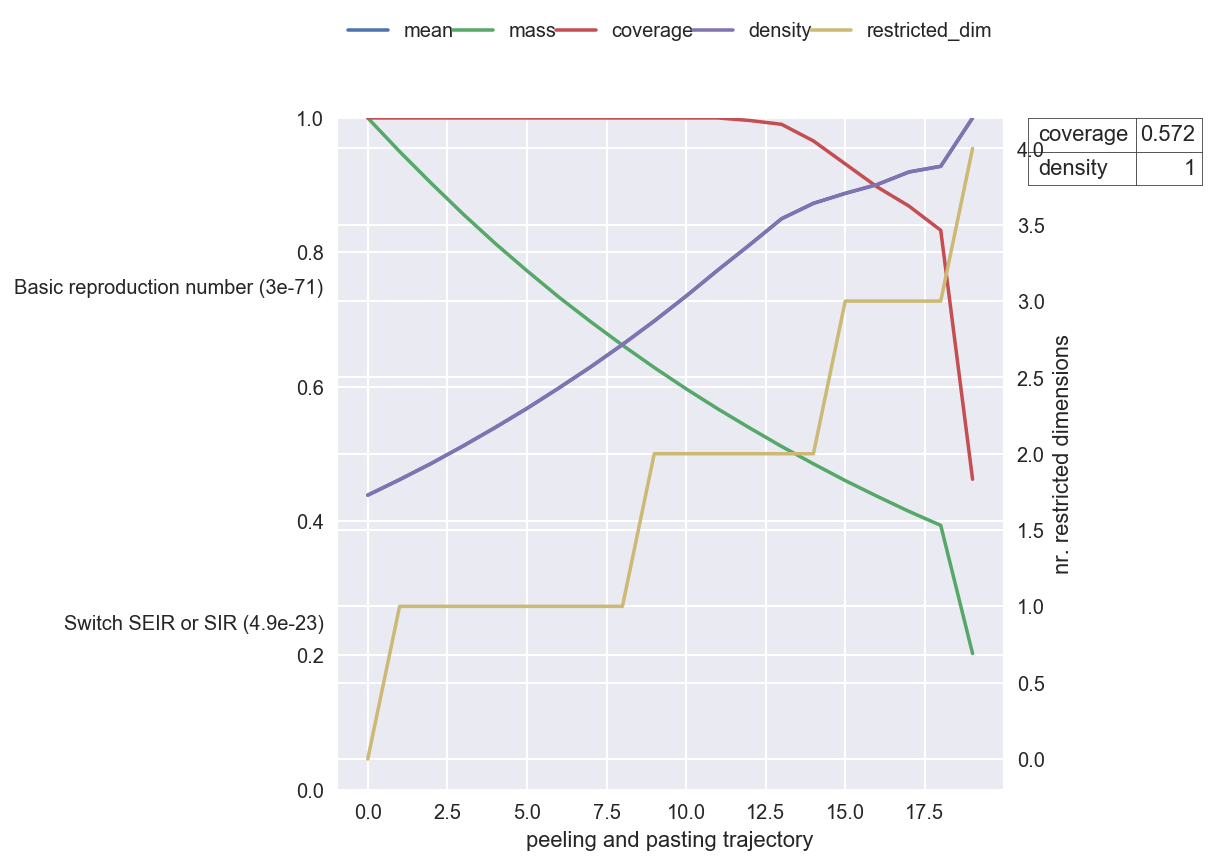

In [23]:
box1.show_ppt()
plt.show()

coverage    0.461977
density     1.000000
mass        0.202500
mean        1.000000
res dim     4.000000
Name: 19, dtype: float64

                             box 19                        
                                min       max     qp values
Basic reproduction number   2.71459   4.99781  3.178174e-46
Case fatality rate         0.107141  0.499818  1.802647e-21
Switch SEIR or SIR              {0}       {0}  1.289149e-08
Average incubation time    0.500041   13.2611  1.000000e+00



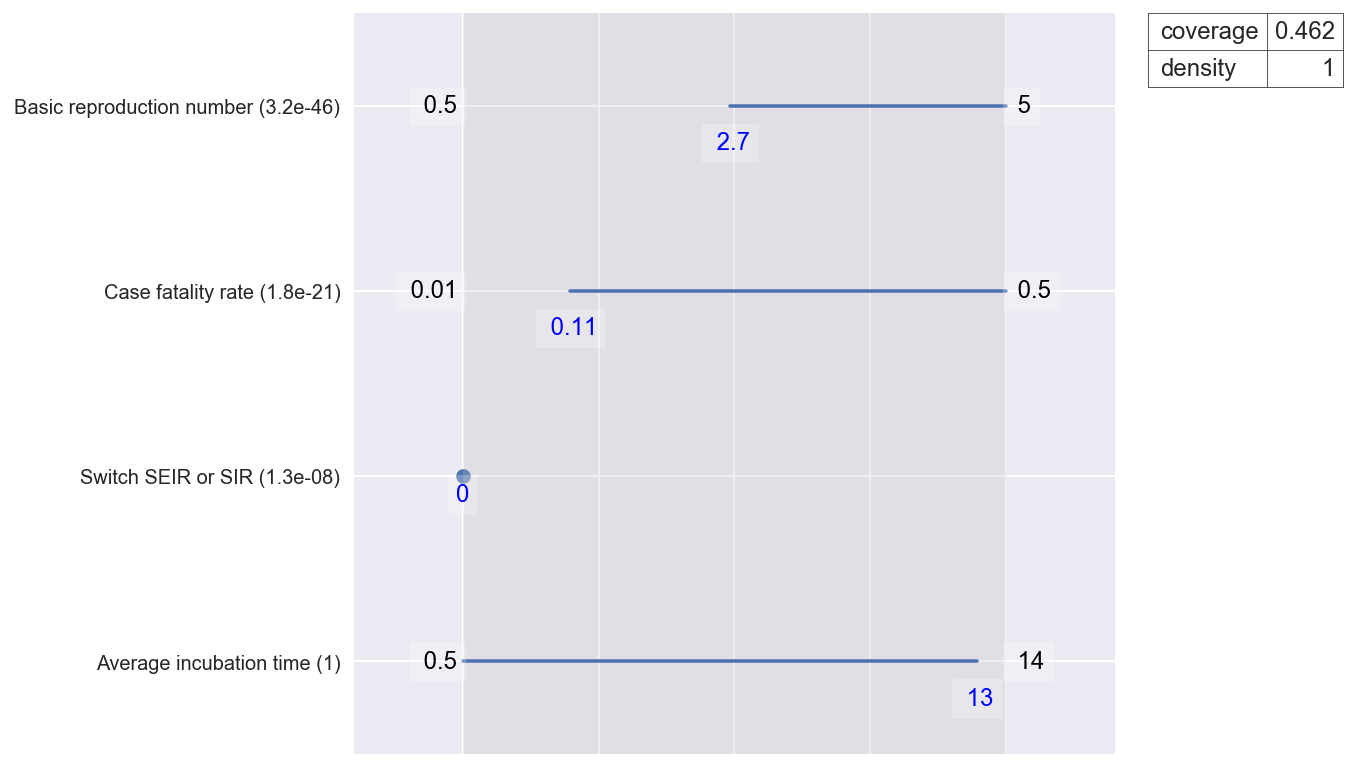

In [24]:
top_box = 19

box1.inspect(top_box)
box1.inspect(top_box, style='graph')

# there are problems with this when you run PRIM multiple 
# times in the same script 

# box1.select(top_box)
# fig = box1.show_pairs_scatter()
# fig.set_size_inches((12,12))
# plt.show()

In [25]:
box2 = combo_prim.find_box()

[MainProcess/INFO] 957 points remaining, containing 283 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.796923076923077, returning dump box


In [27]:
ICD.display(combo_prim.boxes_to_dataframe())
ICD.display(combo_prim.stats_to_dataframe())

box 1                box 2          
                                min       max        min       max
Switch SEIR or SIR              {0}       {0}     {0, 1}    {0, 1}
Basic reproduction number   2.71459   4.99781   0.503083   4.99781
Case fatality rate         0.107141  0.499818  0.0101207  0.499818
Average incubation time    0.500041   13.2611   0.500041   13.9901

,coverage,density,mass,res_dim
box 1,0.461977,1.000000,0.2025,4.0
box 2,0.538023,0.295716,0.7975,0.0


Though the combination of infectious and deceased targets reveals that though `Average incubation time` is seen as a large contributing factor to the failure to meet the specified threshold, the selected range of its uncertainty space covers over 90% of the input uncertainty space. For this reason, we will not be including `Average incubation time` in the target space for policy manipulation.

# CART

For another set of data points, we also ran a CART analysis over the `Deceased population` outcome. Performing scenario discovery with CART and similar input levels allows us to confirm findings through a second methodology. 

,coverage,density,mass,res dim
box 1,0.002751,0.033333,0.050000,2
box 2,0.000000,0.000000,0.143333,2
box 3,0.017882,0.216667,0.050000,1
box 4,0.000000,0.000000,0.092500,2
box 5,0.004127,0.050000,0.050000,2
box 6,0.078404,0.712500,0.066667,2
box 7,0.075653,0.916667,0.050000,2
box 8,0.821183,1.000000,0.497500,2


box 1                box 2            \
                                 min       max        min       max   
Basic reproduction number   0.503083   1.37033   0.503083   1.37033   
Average infectious period    7.00656   10.6881    10.6881    20.998   
Case fatality rate         0.0101207  0.499818  0.0101207  0.499818   

                               box 3                box 4            \
                                 min       max        min       max   
Basic reproduction number    1.37033   1.59453    1.59453   3.79426   
Average infectious period    7.00656    20.998    7.00656    20.998   
Case fatality rate         0.0101207  0.499818  0.0101207  0.107141   

                               box 5               box 6               box 7  \
                                 min       max       min       max       min   
Basic reproduction number    3.79426   4.99781   1.59453   1.96958   1.96958   
Average infectious period    7.00656    20.998   7.00656    20.998   7.00656   
Case fatality rate         0.0101207  0.107141  0.107141  0.499818  0.107141   

                                        box 8            
                                max       min       max  
Basic reproduction number   2.24764   2.24764   4.99781  
Average infectious period    20.998   7.00656    20.998  
Case fatality rate         0.499818  0.107141  0.499818

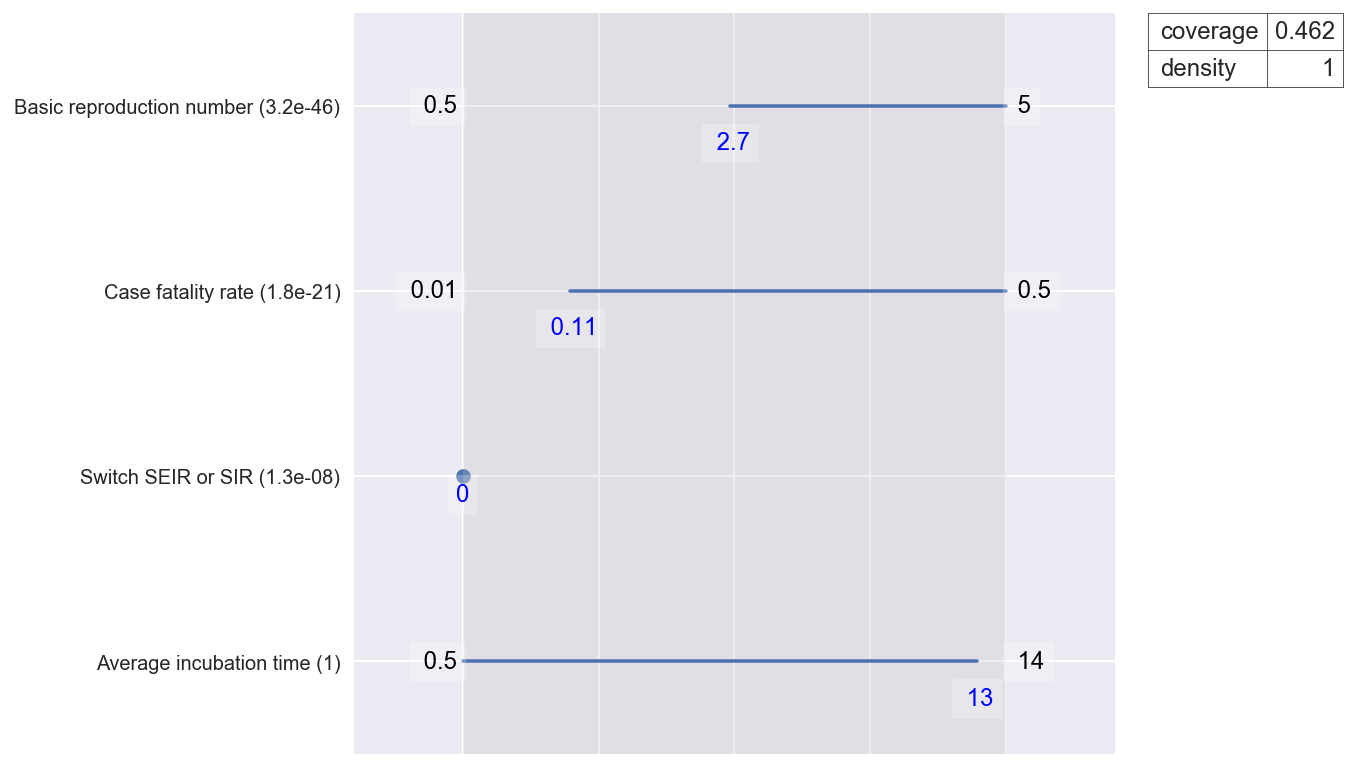

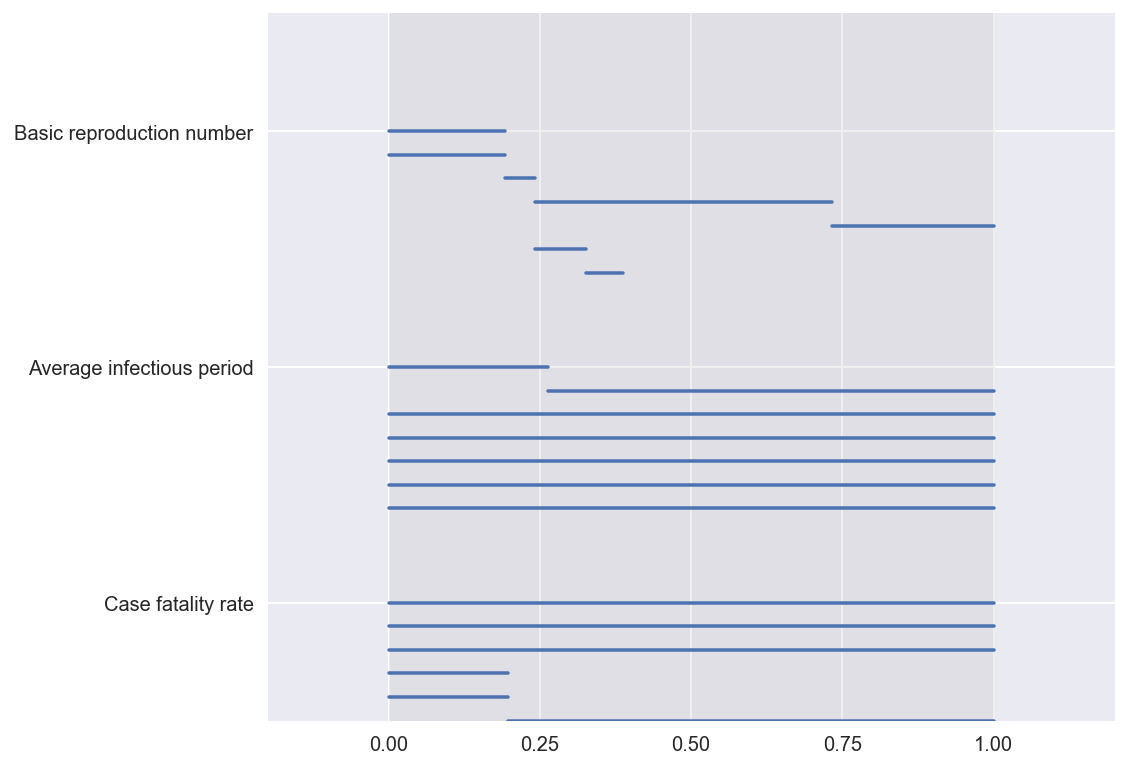

In [28]:
cart_deceased = cart.setup_cart(results, classifyDeceased, mass_min=0.05)
cart_deceased.build_tree()

ICD.display(cart_deceased.stats_to_dataframe())
ICD.display(cart_deceased.boxes_to_dataframe())

cart_deceased.display_boxes(together=True)
plt.show()

In [29]:
cart_infectious = cart.setup_cart(results, classifyInfectious, mass_min=0.05)
cart_infectious.build_tree()

ICD.display(cart_infectious.stats_to_dataframe())
ICD.display(cart_infectious.boxes_to_dataframe())

# there are problems with this when you run CART multiple 
# times in the same script 

#cart_infectious.display_boxes(together=True)
#plt.show()

,coverage,density,mass,res dim
box 1,0.000000,0.000000,0.340833,1
box 2,0.012678,0.133333,0.050000,1
box 3,0.000000,NaN,0.000000,2
box 4,0.167987,0.834646,0.105833,2
box 5,0.085578,0.482143,0.093333,2
box 6,0.309033,1.000000,0.162500,2
box 7,0.207607,0.992424,0.110000,2
box 8,0.217116,0.830303,0.137500,2


box 1              box 2              box 3  \
                                min      max       min      max       min   
Basic reproduction number  0.503083  2.03391   2.03391  2.25823   2.25823   
Switch SEIR or SIR           {0, 1}   {0, 1}    {0, 1}   {0, 1}       {0}   
Average incubation time    0.500041  13.9901  0.500041  13.9901  0.500041   

                                       box 4             box 5           \
                               max       min      max      min      max   
Basic reproduction number  4.99781   2.25823  3.15537  2.25823  3.15537   
Switch SEIR or SIR             {0}    {0, 1}   {0, 1}   {0, 1}   {0, 1}   
Average incubation time    13.9901  0.500041  7.87339  7.87339  13.9901   

                              box 6             box 7             box 8  \
                                min      max      min      max      min   
Basic reproduction number   3.15537  4.99781  3.15537  4.99781  3.15537   
Switch SEIR or SIR           {0, 1}   {0, 1}   {0, 1}   {0, 1}   {0, 1}   
Average incubation time    0.500041  5.68514  5.68514  9.61591  9.61591   

                                    
                               max  
Basic reproduction number  4.99781  
Switch SEIR or SIR          {0, 1}  
Average incubation time    13.9901

In [30]:
cart_both = cart.setup_cart(results, classifyBoth, mass_min=0.05)
cart_both.build_tree()

ICD.display(cart_both.stats_to_dataframe())
ICD.display(cart_both.boxes_to_dataframe())

# there are problems with this when you run CART multiple 
# times in the same script 

#cart_both.display_boxes(together=True)
#plt.show()

,coverage,density,mass,res dim
box 1,0.000000,0.000000,0.350833,1
box 2,0.022814,0.200000,0.050000,1
box 3,0.000000,0.000000,0.108333,2
box 4,0.000000,NaN,0.000000,4
box 5,0.000000,NaN,0.000000,4
box 6,0.245247,0.697297,0.154167,2
box 7,0.209125,0.982143,0.093333,4
box 8,0.328897,1.000000,0.144167,4
box 9,0.193916,0.857143,0.099167,3


box 1                box 2            \
                                 min       max        min       max   
Basic reproduction number   0.503083   2.07732    2.07732   2.30203   
Case fatality rate         0.0101207  0.499818  0.0101207  0.499818   
Switch SEIR or SIR            {0, 1}    {0, 1}     {0, 1}    {0, 1}   
Average infectious period    7.00656    20.998    7.00656    20.998   
Average incubation time     0.500041   13.9901   0.500041   13.9901   

                               box 3               box 4               box 5  \
                                 min       max       min       max       min   
Basic reproduction number    2.30203   4.99781   2.30203   4.99781   2.30203   
Case fatality rate         0.0101207  0.103128  0.103128  0.499818  0.103128   
Switch SEIR or SIR            {0, 1}    {0, 1}       {0}       {0}       {0}   
Average infectious period    7.00656    20.998   7.00656    20.998   7.00656   
Average incubation time     0.500041   13.9901  0.500041   3.43514   3.43514   

                                        box 6               box 7            \
                                max       min       max       min       max   
Basic reproduction number   4.99781   2.30203   3.15537   3.15537   4.99781   
Case fatality rate         0.499818  0.103128  0.499818  0.103128  0.499818   
Switch SEIR or SIR              {0}    {0, 1}    {0, 1}    {0, 1}    {0, 1}   
Average infectious period    20.998   7.00656    20.998   7.00656   12.0152   
Average incubation time     13.9901  0.500041   13.9901  0.500041   10.1834   

                              box 8               box 9            
                                min       max       min       max  
Basic reproduction number   3.15537   4.99781   3.15537   4.99781  
Case fatality rate         0.103128  0.499818  0.103128  0.499818  
Switch SEIR or SIR           {0, 1}    {0, 1}    {0, 1}    {0, 1}  
Average infectious period   12.0152    20.998   7.00656    20.998  
Average incubation time    0.500041   10.1834   10.1834   13.9901

# Conclusion

Both PRIM and CART analysis have found similar solutions, that `Case Fataility Rate` and `Base reproduction number` have significant influence on a failure to meet the specified levels for `Infectious population` and `Deceased population`, both independently and in combination. 

These results, along with the results of sensitivity analysis (found in `03_Sobol_Analysis.ipynb` and `04_RandomForests_Analysis.ipynb` indicate that these two uncertainty ranges should be the targets of actions developed in the next steps of a Dynamic Adaptive Policy Pathways approach to model analysis and decision making. 